In [1]:
import numpy as np
 
import scipy.misc
import time
import os
import h5py
from scipy.ndimage.filters import gaussian_filter, median_filter

from keras.models import Sequential, Model
from keras.layers import Conv2D, Input, MaxPooling2D, Flatten, Dense, Dropout,UpSampling2D, merge
from keras import backend as K


import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/home/zomi/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Upsample Layer

In [2]:
from keras import backend as K
from keras.engine.topology import Layer
import tensorflow as tf

class Upsimple(Layer):
    """
    Upsample层
    """
    def __init__(self, size=(1,1), target_size=None, **kwargs):
        self.target_size = tuple(target_size) if target_size is not None else None
        self.size = tuple(size) if size is not None else None
        
        self.data_format = K.image_data_format()
        assert self.data_format in {'channels_last', 'channels_first'}, \
        'data_format not in {tf, th}'
    
        super(Upsimple, self).__init__(**kwargs)
    
    def call(self, x):
        if self.target_size is not None:
            x = self.__resize_bilinear_with_target(x,
                                        target_size = self.target_size,
                                        data_format = self.data_format)
        else:
            x = self.__resize_bilinear_with_factor(x,
                                        factor_size = self.size,
                                        data_format = self.data_format)
        return x
    
    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_first':
            width = int(self.size[0] * input_shape[2] if input_shape[2] is not None else None)
            height = int(self.size[1] * input_shape[3] if input_shape[3] is not None else None)
            if self.target_size is not None:
                width = self.target_size[0]
                height = self.target_size[1]
            return (input_shape[0], input_shape[1], width, height)
        else:
            raise Exception('Invalid data_format: ' + self.data_format)
                
    def __resize_bilinear_with_target(self, x, target_size=None, data_format=None):
        """
        upsimple input image with bilinear method by setup target.
        """
        target_height = target_size[0]
        target_width = target_size[1]
        if data_format == 'channels_first':
            new_shape = tf.constant(np.array((target_height, target_width)).astype('int32'))
            X = K.permute_dimensions(x, [0, 2, 3, 1])
            X = tf.image.resize_bilinear(X, new_shape)
            X = K.permute_dimensions(X, [0, 3, 1, 2])
            return X
        else:
            raise Exception("Invilid data format", data_format)
    
    def __resize_bilinear_with_factor(self, x, factor_size=None, data_format=None):
        """
        upsimple input iamge with bilinear method by number factor.
        """
        height_factor = factor_size[0]
        width_factor = factor_size[1]
        if data_format == 'channels_first':
            height = x.shape[2] * height_factor
            width = x.shape[3] * width_factor
            new_shape = tf.constant(np.array([height, width]).astype('int32'))
            X = K.permute_dimensions(x, [0, 2, 3, 1])
            X = tf.image.resize_bilinear(X, new_shape)
            X = K.permute_dimensions(X, [0, 3, 1, 2])
            return X
        else:
            raise Exception("invilid data format", data_format)

# X = Upsimple(size=(32,32))(fcn_vgg16)

In [3]:
def FCN_Vgg16(input_shape=None):

    if input_shape:
        img_input = Input(shape=input_shape)
    else:
        input_shape = (3, 224, 224)
        img_input = Input(shape=input_shape)
    
    target_height, target_width = input_shape[1], input_shape[2]
        
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    # Convolutional layers transfered from fully-connected layers
    x = Conv2D(4096, (7, 7), activation='relu', padding='same', name='fc1')(x)
    x = Dropout(0.5)(x)
    x = Conv2D(4096, (1, 1), activation='relu', padding='same', name='fc2')(x)
    x = Dropout(0.5)(x)
    x = Conv2D(1000, (1, 1), activation='linear', padding='same', strides=(1, 1), name='predictions_1000')(x)
    
    X = Upsimple(size=(32,32))(x)
#     X = Upsimple(target_size=(224,224))(x)
    
    # Create model
    model = Model(img_input, X)

    #transfer if weights have not been created
    weights_path = "fcn_vgg16_weights_tf_dim_ordering_tf_kernels.h5"
    if os.path.isfile(weights_path) == False:
        flattened_layers = model.layers
        index = {}
        for layer in flattened_layers:
            if layer.name:
                index[layer.name]=layer

        for layer in vgg16.layers:
            weights = layer.get_weights()
            if layer.name=='fc1':
                weights[0] = np.reshape(weights[0], (7,7,512,4096))
            elif layer.name=='fc2':
                weights[0] = np.reshape(weights[0], (1,1,4096,4096))
            elif layer.name=='predictions':
                layer.name='predictions_1000'
                weights[0] = np.reshape(weights[0], (1,1,4096,1000))
            if layer.name in index:
                index[layer.name].set_weights(weights)
        model.save_weights(weights_path)
        print( 'Successfully transformed!')
    #else load weights
    else:
        model.load_weights(weights_path, by_name=True)
        print( 'Already transformed!')
        
    return model

fcn_vgg16 = FCN_Vgg16()
print('Model loaded.')
fcn_vgg16.summary()

Already transformed!
Model loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 224, 224)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 224, 224)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 224, 224)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 112, 112)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 112, 112)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 112, 112)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 

In [3]:
def FCN_Vgg16(input_shape=None):

    if input_shape:
        img_input = Input(shape=input_shape)
    else:
        input_shape = (3, 224, 224)
        img_input = Input(shape=input_shape)
    
    target_height, target_width = input_shape[1], input_shape[2]
        
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
    
    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    
    # Convolutional layers transfered from fully-connected layers
    x = Conv2D(4096, (7, 7), activation='relu', padding='same', name='fc1')(x)
    x = Dropout(0.5)(x)
    x = Conv2D(4096, (1, 1), activation='relu', padding='same', name='fc2')(x)
    x = Dropout(0.5)(x)
    x = Conv2D(1000, (1, 1), activation='relu', padding='same', name='predictions_1000')(x)
        
    x = Upsimple(size=(32,32))(x)
    
    # Create model
    model = Model(img_input, x)   
    return model

fcn_vgg16 = FCN_Vgg16((3,512,512))
fcn_vgg16.summary()

print('Model loaded.')
weights_path = "fcn_vgg16_weights_tf_dim_ordering_tf_kernels.h5"
fcn_vgg16.load_weights(weights_path, by_name=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 512, 512)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 512, 512)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 512, 512)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 256, 256)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 256, 256)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 256, 256)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0         
__________

In [4]:
from PIL import Image
from keras.preprocessing import image 
from keras.applications.imagenet_utils import preprocess_input

def load_image(img_path, show=False):
    img = image.load_img(img_path, target_size=(512,512))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor = preprocess_input(img_tensor)
        
    if show:
        show_img = np.transpose(img_tensor[0], (1,2,0))
        plt.imshow(show_img)
        plt.show()

    return img_tensor
        
image = load_image("image/2007_000129.jpg")
pred = fcn_vgg16.predict(image, batch_size=1)
print("predict finished.")


(1, 3, 512, 512)
predict finished.


In [5]:
image_pred = np.argmax(np.squeeze(pred), axis=0).astype(np.uint8)

(1000, 512, 512)
(512, 512)
[[126 126 126 ..., 234 234 234]
 [126 126 126 ..., 234 234 234]
 [126 126 126 ..., 234 234 234]
 ..., 
 [112 112 112 ..., 100 100 100]
 [112 112 112 ..., 100 100 100]
 [112 112 112 ..., 100 100 100]]


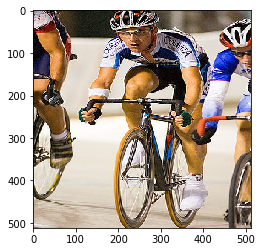

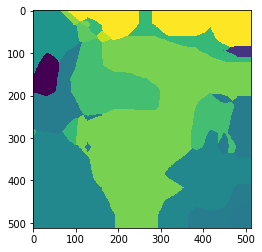

In [6]:
from keras.preprocessing import image 

image = image.load_img("image/2007_000129.jpg", target_size=(512,512))
plt.imshow(image)
plt.show()

plt.imshow(image_pred)
plt.show()